In [1]:
import sys
import os
import pandas as pd

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, tune

In [4]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, encode_labels, train_val_split, \
    get_dimensions, get_device, metrics_c, plot_history, load_best_params, load_tuning_history, print_best_params_nn, save_best_params, save_tuning_history, print_tuning_top_results, plot_param_loss_corr, plot_tuning_heatmap

## Settings

In [5]:
# Set Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [6]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

In [7]:
target = "HistoricalPeriod"

## Data

### Read Features and Targets

In [8]:
X = read_features(path, f_type="tensors")
y = read_targets(path, [target])

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


### Encode Target Labels

In [9]:
y, target_enc, le = encode_labels(y, target)

0 --> Archaic
1 --> Classical
2 --> Hellenistic
3 --> Orientalizing


In [10]:
y = {
    subset: torch.tensor(_y[target_enc].values, dtype=torch.long, device=device)
    for subset, _y in y.items()
}

### Train-Validation Split


In [11]:
X, y = train_val_split(X, y)

### Dimensions

In [12]:
X_dim, y_dim = get_dimensions(X, y, le)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 4


### Torch Datasets and Dataloaders

In [13]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Define Parameter Grid

In [14]:
criterion = nn.CrossEntropyLoss()
metrics = metrics_c
log_metrics = ["accuracy"]

param_grid = {
    # Architecture Params
    # "hidden_size": [128, 256, 512, 1024],
    "hidden_size": [128, 256, 512, 1024],
    "activation": ["relu", "gelu"],
    # "dropout": [0, 0.1, 0.3, 0.5],
    "dropout": [0.05, 0.1, 0.2],
    # "blocks": [1, 2, 3, 5, 10],
    "blocks": [1, 2, 3],
    "hidden_size_pattern": ["decreasing", "constant"],

    # Training Params
    # "lr": [1e-2, 1e-3, 1e-4, 1e-5],
    "lr": [1e-2, 5e-3, 1e-3, 5e-4],
    # "weight_decay": [1e-5, 1e-6, 1e-7],
}

## Load or Initialize Best Params & Tuning History

In [15]:
# Load or initialize best params dictionary and tuning history table
path_params = "best_params.json"
path_history = "tuning_history.csv"

best_params = load_best_params(path_params)
print(f"Best Params Available for {len(best_params.keys())} Models")

tuning_histories = load_tuning_history(path_history)

Best Params Available for 5 Models


## Run Model Tuning



In [16]:
flag_new_model = False

def tune_helper(fts):
    global flag_new_model, best_params, tuning_histories
    ft = " + ".join(fts)

    if ft not in best_params.keys():
        flag_new_model = True
        print(f"\n🔄 Tuning MLP with '{ft.upper()}' Features")
        tuning_result, tuning_history = tune(
            param_grid,
            [X_dim[_ft] for _ft in fts],
            y_dim,
            loaders["train"][ft],
            loaders["val"][ft],
            criterion,
            metrics,
            device,
            log_metrics=log_metrics,
            log_per_M=100,
            chronology_target="periods"
        )

        best_params[ft] = tuning_result
        tuning_histories[ft] = tuning_history
    else:
        print(f"\n✅ MLP with '{ft.upper()}' Features Already Tuned.", end=" ")
        print_best_params_nn(best_params[ft], param_grid, y_dim, log_metrics)

for ft in feature_types:
    tune_helper([ft])

for ft_txt, ft_img in feature_type_combos:
    tune_helper([ft_txt, ft_img])


✅ MLP with 'TFIDF' Features Already Tuned. Execution Time: 4m 52s
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+------------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |     lr |  val_loss | accuracy_0 |
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+------------+
|      BEST |         512 |       relu |     0.2 |      3 |            constant |   0.01 |    0.3856 |     0.8430 |
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+------------+

✅ MLP with 'BERT' Features Already Tuned. Execution Time: 8m 51s
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+------------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |     lr |  val_loss | accuracy_0 |
+-----------+-------------+------------+---------+-----

## Save Best Params & Tuning History

In [17]:
save_best_params("best_params.json", best_params, flag_new_model)
save_tuning_history("tuning_history.csv", tuning_histories, flag_new_model)

✅ Saved best parameters to best_params.json
✅ Saved tuning history to tuning_history.csv


## Evaluate Tuning Results

(0.3856319785118103, 0.820830762386322)


📈 Tuning results for TFIDF features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
276,relu,3,0.20,512,constant,0.010,0.306947,0.385632,0.843023,0.667483,0.593578,0.621356
117,relu,2,0.05,512,constant,0.005,0.238909,0.434400,0.813953,0.652807,0.578726,0.606396
285,relu,3,0.20,1024,constant,0.005,0.243781,0.439634,0.808140,0.649352,0.573873,0.602846
92,relu,1,0.20,1024,constant,0.010,0.528353,0.444282,0.802326,0.646216,0.569020,0.599190
208,relu,3,0.05,512,decreasing,0.010,0.417903,0.444787,0.779070,0.477619,0.560196,0.504111



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
276,relu,3,0.2,512,constant,0.010,0.306947,0.385632,0.843023,0.667483,0.593578,0.621356
152,relu,2,0.1,1024,decreasing,0.010,0.263528,0.513245,0.831395,0.551170,0.575637,0.556868
284,relu,3,0.2,1024,constant,0.010,0.356325,0.521954,0.831395,0.663979,0.579167,0.612500
88,relu,1,0.2,1024,decreasing,0.010,0.302624,0.451494,0.819767,0.658712,0.571814,0.605692
253,relu,3,0.1,1024,constant,0.005,0.341591,0.504209,0.813953,0.404390,0.413529,0.408903


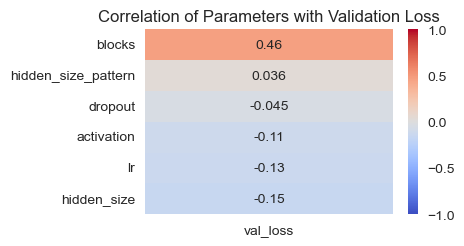

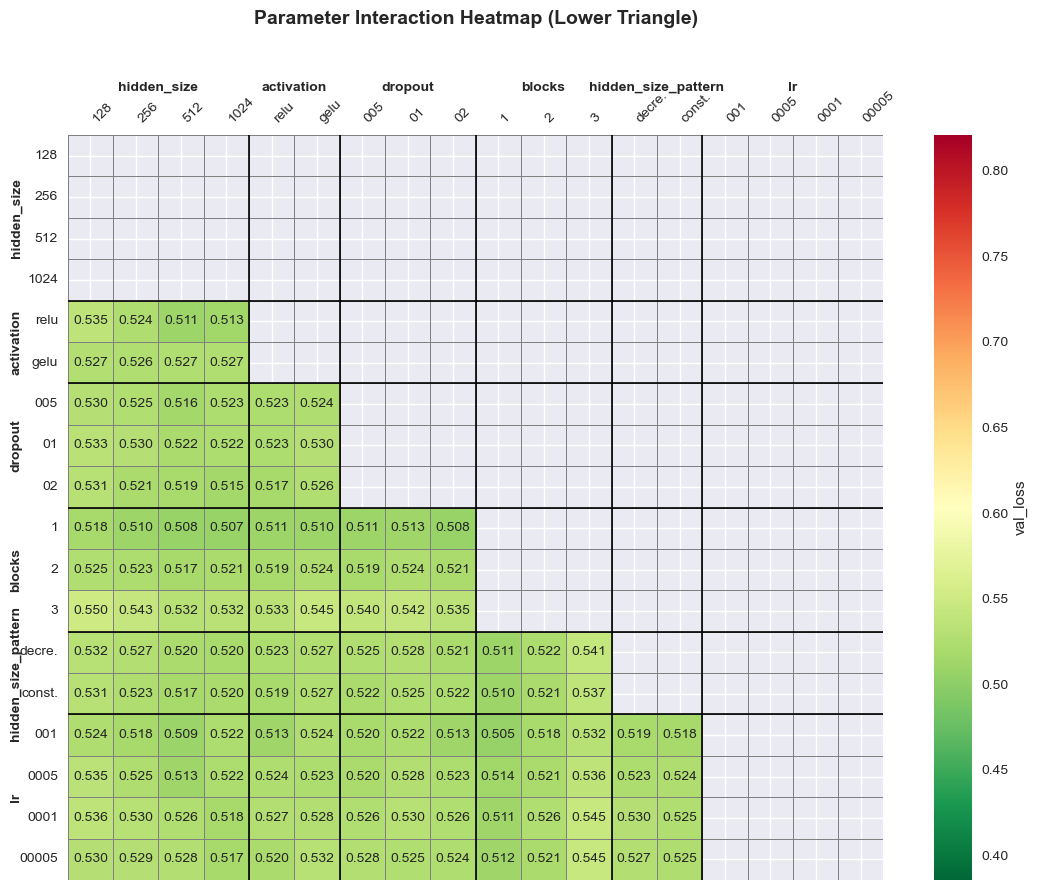



📈 Tuning results for BERT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
1146,gelu,3,0.2,1024,decreasing,0.0010,0.489479,0.568105,0.767442,0.506690,0.472010,0.484905
903,gelu,1,0.1,128,constant,0.0005,0.471567,0.568997,0.755814,0.623613,0.459951,0.499726
1004,gelu,2,0.1,256,constant,0.0100,0.513703,0.571634,0.738372,0.376208,0.359853,0.359222
907,gelu,1,0.1,256,decreasing,0.0005,0.532407,0.573259,0.744186,0.617100,0.454951,0.494203
931,gelu,1,0.2,128,decreasing,0.0005,0.531270,0.573716,0.750000,0.621936,0.453922,0.494763



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
1070,gelu,3,0.05,256,constant,0.0010,0.437659,0.605830,0.790698,0.518690,0.483186,0.496678
1019,gelu,2,0.10,1024,decreasing,0.0005,0.471569,0.586206,0.790698,0.644032,0.476127,0.517125
899,gelu,1,0.10,128,decreasing,0.0005,0.458094,0.576162,0.784884,0.642544,0.471274,0.512944
834,relu,3,0.20,128,decreasing,0.0010,0.537322,0.593576,0.779070,0.647358,0.462892,0.505934
755,relu,2,0.20,512,decreasing,0.0005,0.517922,0.601506,0.773256,0.638791,0.462745,0.504976


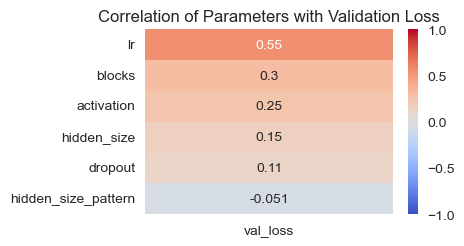

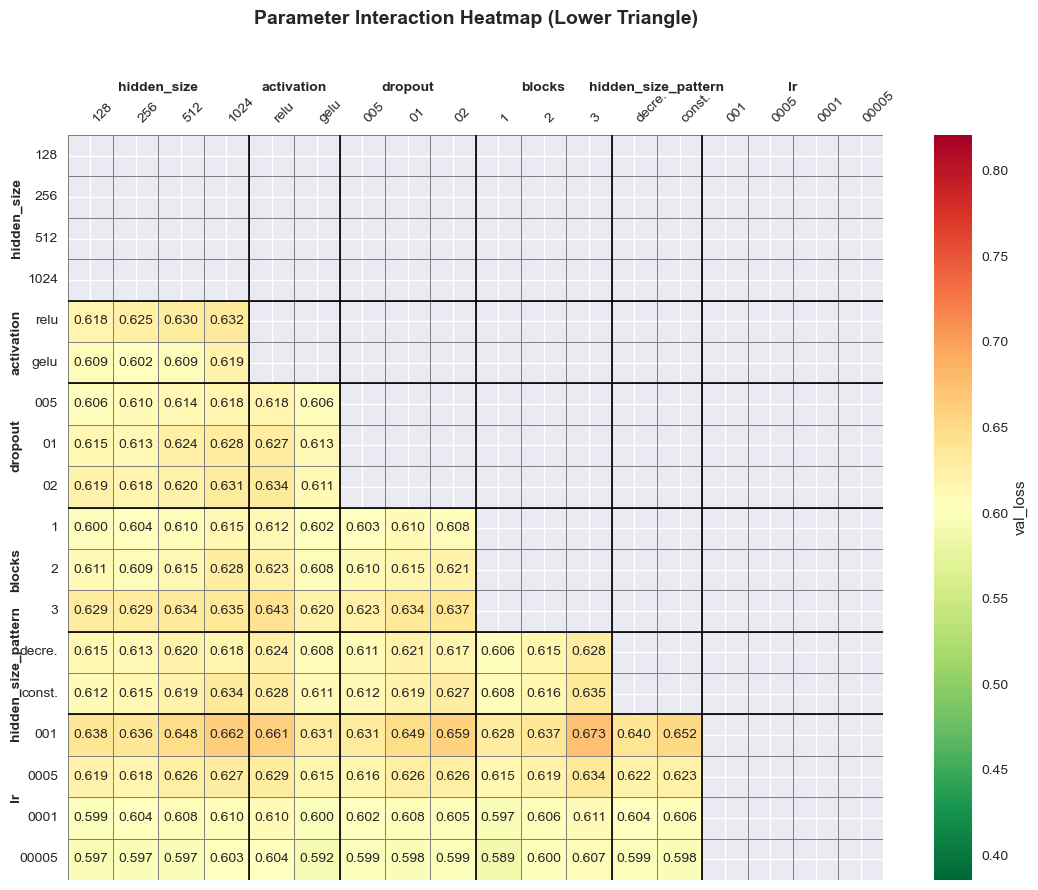



📈 Tuning results for CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
1190,relu,1,0.10,128,constant,0.0010,0.704661,0.682622,0.668605,0.347066,0.313382,0.304394
1163,relu,1,0.05,256,decreasing,0.0005,0.631237,0.686381,0.674419,0.355148,0.315882,0.307617
1494,gelu,1,0.10,512,constant,0.0010,0.573505,0.689900,0.680233,0.357160,0.319559,0.311562
1459,gelu,1,0.05,512,decreasing,0.0005,0.652074,0.690240,0.680233,0.353571,0.320735,0.313750
1462,gelu,1,0.05,512,constant,0.0010,0.626915,0.690973,0.674419,0.358238,0.314706,0.304404



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
1155,relu,1,0.05,128,decreasing,0.0005,0.668296,0.698448,0.691860,0.367254,0.325735,0.318730
1179,relu,1,0.05,1024,decreasing,0.0005,0.611757,0.693262,0.680233,0.343981,0.321912,0.315937
1186,relu,1,0.10,128,decreasing,0.0010,0.640612,0.701290,0.680233,0.361359,0.318382,0.309255
1170,relu,1,0.05,512,decreasing,0.0010,0.631509,0.698407,0.680233,0.362512,0.318382,0.310057
1599,gelu,2,0.10,1024,constant,0.0005,0.684349,0.713162,0.680233,0.366307,0.317206,0.306824


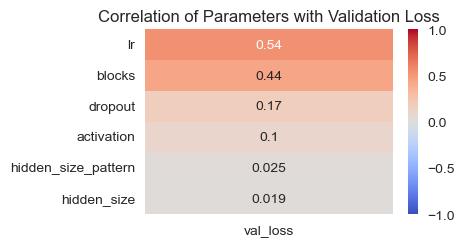

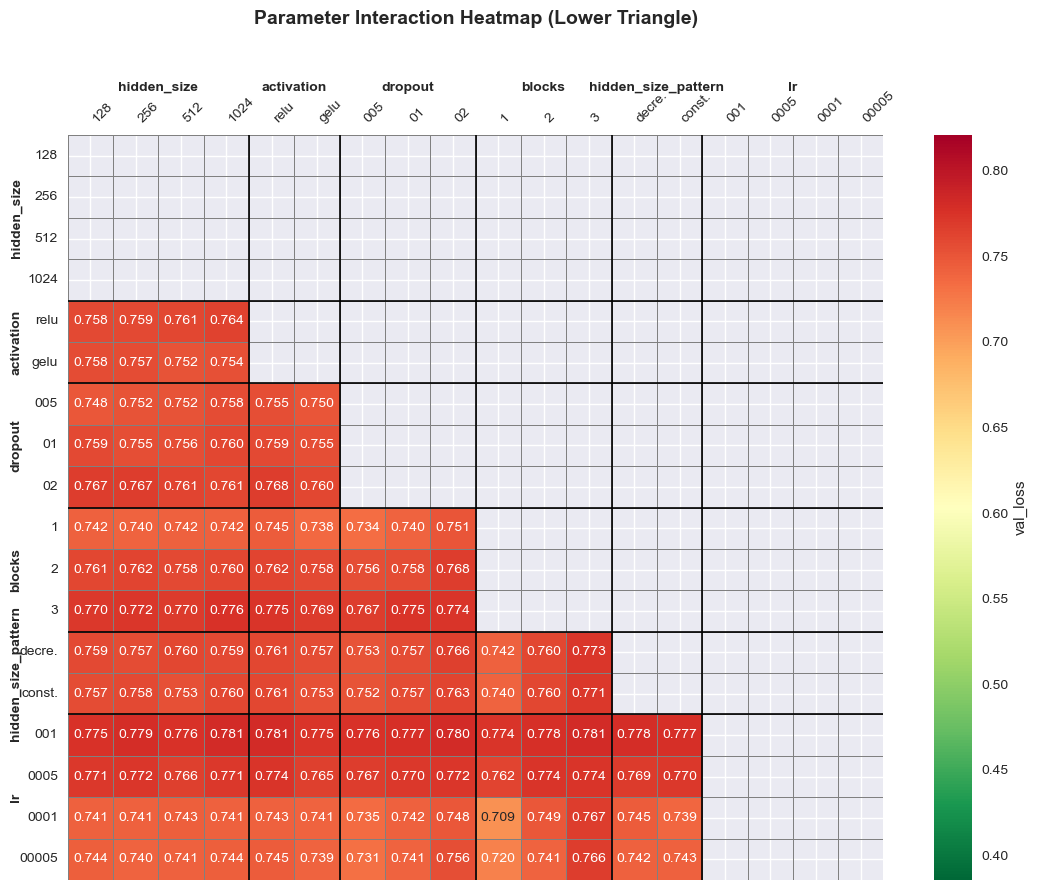



📈 Tuning results for RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
1834,relu,2,0.05,256,decreasing,0.0010,0.579055,0.618696,0.680233,0.503439,0.488284,0.487242
1770,relu,1,0.10,256,decreasing,0.0010,0.584131,0.619452,0.691860,0.464504,0.487402,0.443246
1814,relu,1,0.20,512,constant,0.0010,0.631569,0.621910,0.703488,0.471462,0.495931,0.454778
1801,relu,1,0.20,256,decreasing,0.0050,0.616669,0.622280,0.703488,0.497476,0.412745,0.425007
2119,gelu,2,0.05,128,constant,0.0005,0.612069,0.623426,0.686047,0.483095,0.401716,0.410497



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
1932,relu,3,0.05,256,constant,0.0100,0.621263,0.630794,0.720930,0.627038,0.502255,0.531681
1983,relu,3,0.10,1024,constant,0.0005,0.664135,0.655474,0.715116,0.392912,0.335735,0.328357
1843,relu,2,0.05,512,decreasing,0.0005,0.607538,0.648453,0.715116,0.636292,0.417745,0.454279
1789,relu,1,0.10,1024,constant,0.0050,0.610481,0.651678,0.709302,0.466299,0.496078,0.439933
1771,relu,1,0.10,256,decreasing,0.0005,0.600129,0.630850,0.709302,0.492669,0.498431,0.473496


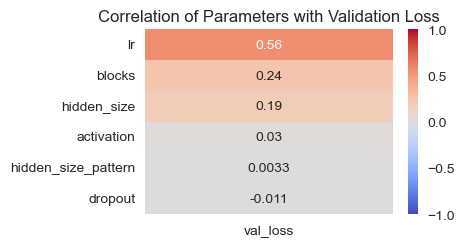

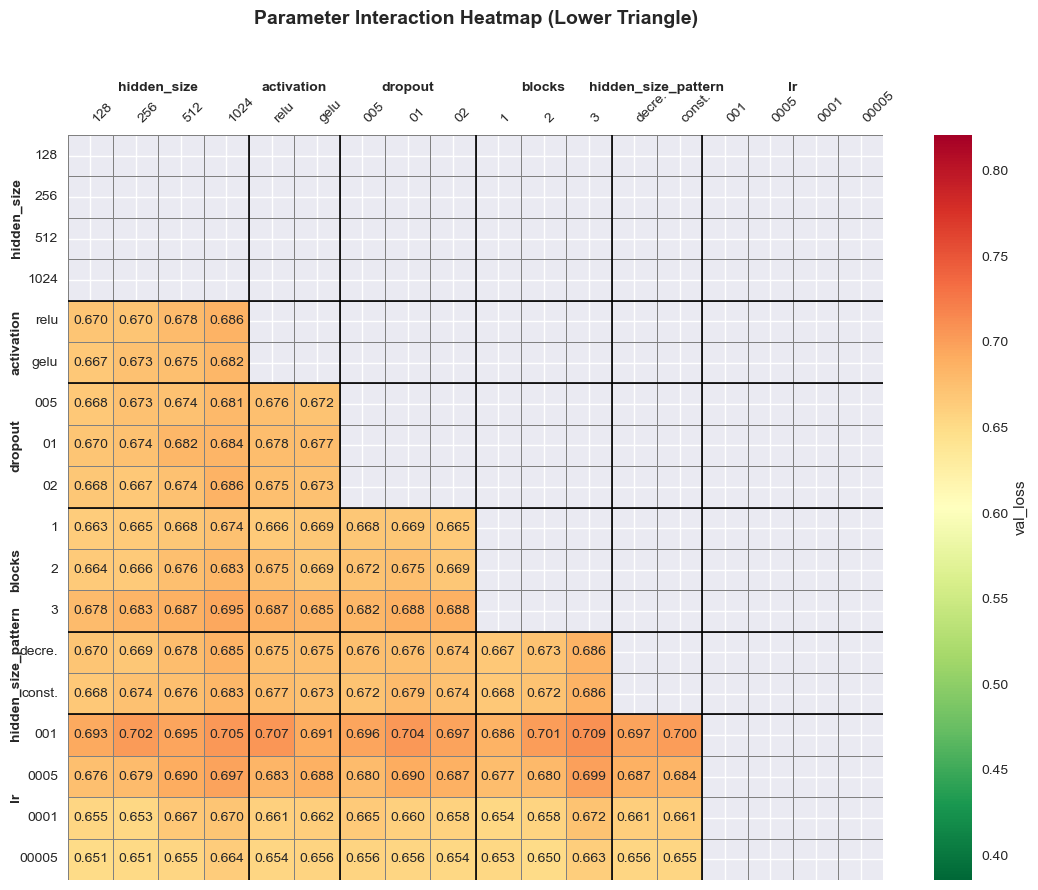



📈 Tuning results for VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
2775,gelu,2,0.20,512,constant,0.0005,0.628574,0.673355,0.691860,0.604549,0.486225,0.512814
2751,gelu,2,0.10,1024,constant,0.0005,0.635801,0.673978,0.697674,0.609684,0.410245,0.446241
2594,gelu,1,0.05,128,decreasing,0.0010,0.629427,0.675065,0.703488,0.609722,0.415098,0.452680
2599,gelu,1,0.05,128,constant,0.0005,0.602455,0.677106,0.715116,0.621887,0.420098,0.457775
2785,gelu,3,0.05,128,decreasing,0.0050,0.677518,0.680316,0.686047,0.363095,0.320882,0.311305



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
2703,gelu,2,0.05,256,constant,0.0005,0.591034,0.693154,0.726744,0.631065,0.426275,0.464787
2363,relu,1,0.10,1024,decreasing,0.0005,0.582440,0.681416,0.720930,0.632892,0.421422,0.458396
2346,relu,1,0.10,256,decreasing,0.0010,0.566618,0.700595,0.720930,0.624632,0.423775,0.462194
2319,relu,1,0.05,256,constant,0.0005,0.598975,0.704601,0.720930,0.379795,0.342941,0.338936
2743,gelu,2,0.10,512,constant,0.0005,0.597082,0.692249,0.715116,0.624275,0.498578,0.527099


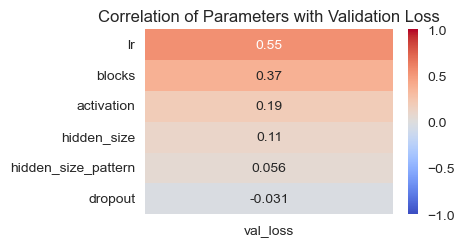

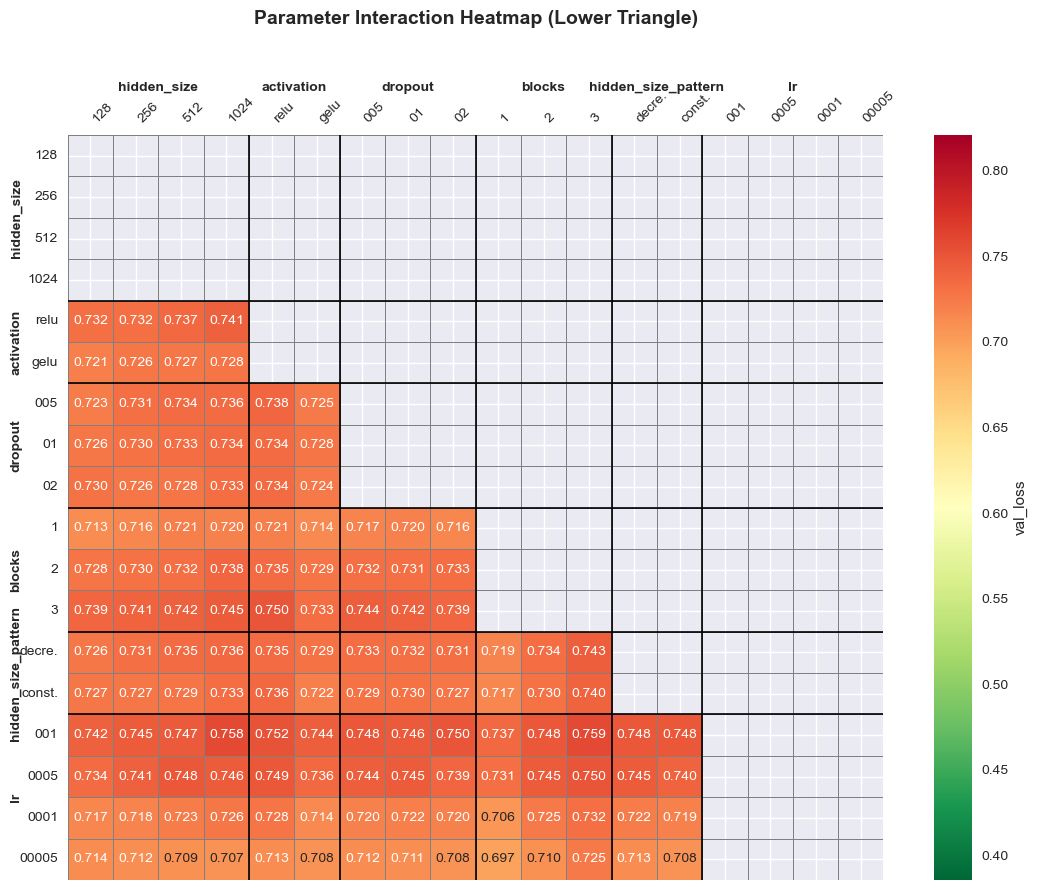



📈 Tuning results for TFIDF + CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
280,relu,3,0.20,1024,decreasing,0.010,0.374498,0.450342,0.796512,0.395000,0.406029,0.400357
176,relu,2,0.20,512,decreasing,0.010,0.422892,0.459004,0.790698,0.392745,0.407059,0.398541
57,relu,1,0.10,1024,decreasing,0.005,0.355824,0.459639,0.790698,0.640842,0.559314,0.591528
281,relu,3,0.20,1024,decreasing,0.005,0.483055,0.468110,0.790698,0.405343,0.389412,0.390250
29,relu,1,0.05,1024,constant,0.005,0.343121,0.470999,0.808140,0.649636,0.575049,0.603207



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
220,relu,3,0.05,1024,constant,0.0100,0.320809,0.570007,0.819767,0.409144,0.413676,0.410912
25,relu,1,0.05,1024,decreasing,0.0050,0.289503,0.479763,0.813953,0.654009,0.581078,0.606981
40,relu,1,0.10,256,decreasing,0.0100,0.384880,0.475101,0.813953,0.654020,0.570490,0.603400
29,relu,1,0.05,1024,constant,0.0050,0.343121,0.470999,0.808140,0.649636,0.575049,0.603207
423,gelu,2,0.10,128,constant,0.0005,0.439294,0.518224,0.808140,0.651284,0.566814,0.600000


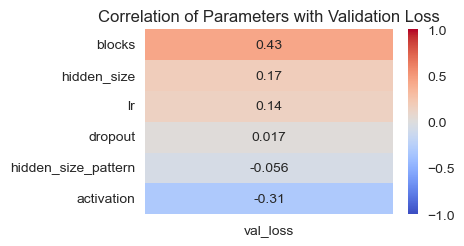

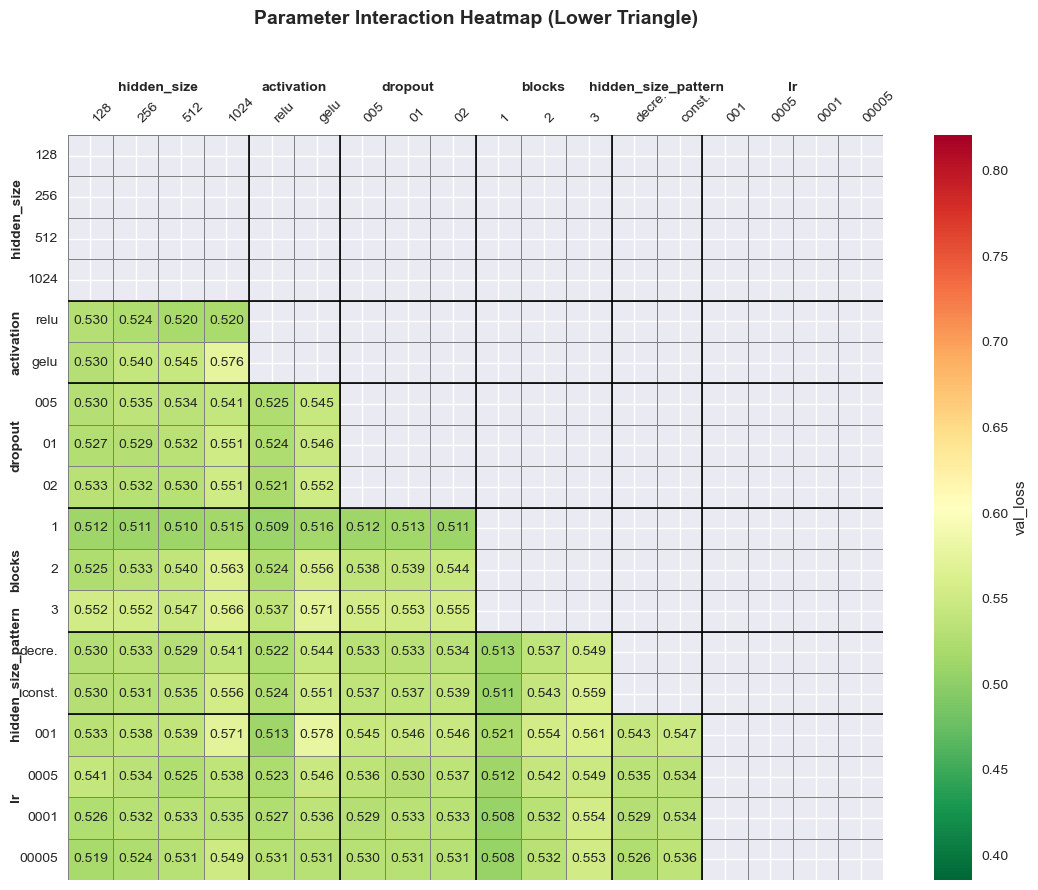



📈 Tuning results for TFIDF + RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
535,gelu,3,0.10,512,constant,0.0005,0.401425,0.419553,0.819767,0.655637,0.576520,0.607724
27,relu,1,0.05,1024,decreasing,0.0005,0.245197,0.422071,0.819767,0.656896,0.495686,0.534532
443,gelu,2,0.10,1024,decreasing,0.0005,0.426178,0.426356,0.813953,0.653297,0.571667,0.603924
59,relu,1,0.10,1024,decreasing,0.0005,0.302314,0.426482,0.813953,0.651957,0.576373,0.605397
478,gelu,2,0.20,1024,constant,0.0010,0.360341,0.428670,0.784884,0.496368,0.556814,0.517905



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
32,relu,1,0.1,128,decreasing,0.0100,0.176506,0.513014,0.837209,0.591169,0.579314,0.582557
70,relu,1,0.2,128,constant,0.0010,0.342199,0.432668,0.837209,0.664622,0.586373,0.617148
155,relu,2,0.1,1024,decreasing,0.0005,0.309928,0.459696,0.831395,0.581696,0.580343,0.580710
54,relu,1,0.1,512,constant,0.0010,0.188805,0.439769,0.831395,0.663031,0.580343,0.612989
84,relu,1,0.2,512,constant,0.0100,0.190065,0.482615,0.831395,0.663031,0.580343,0.612989


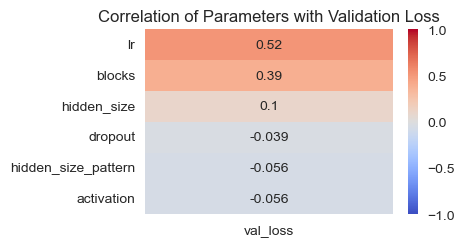

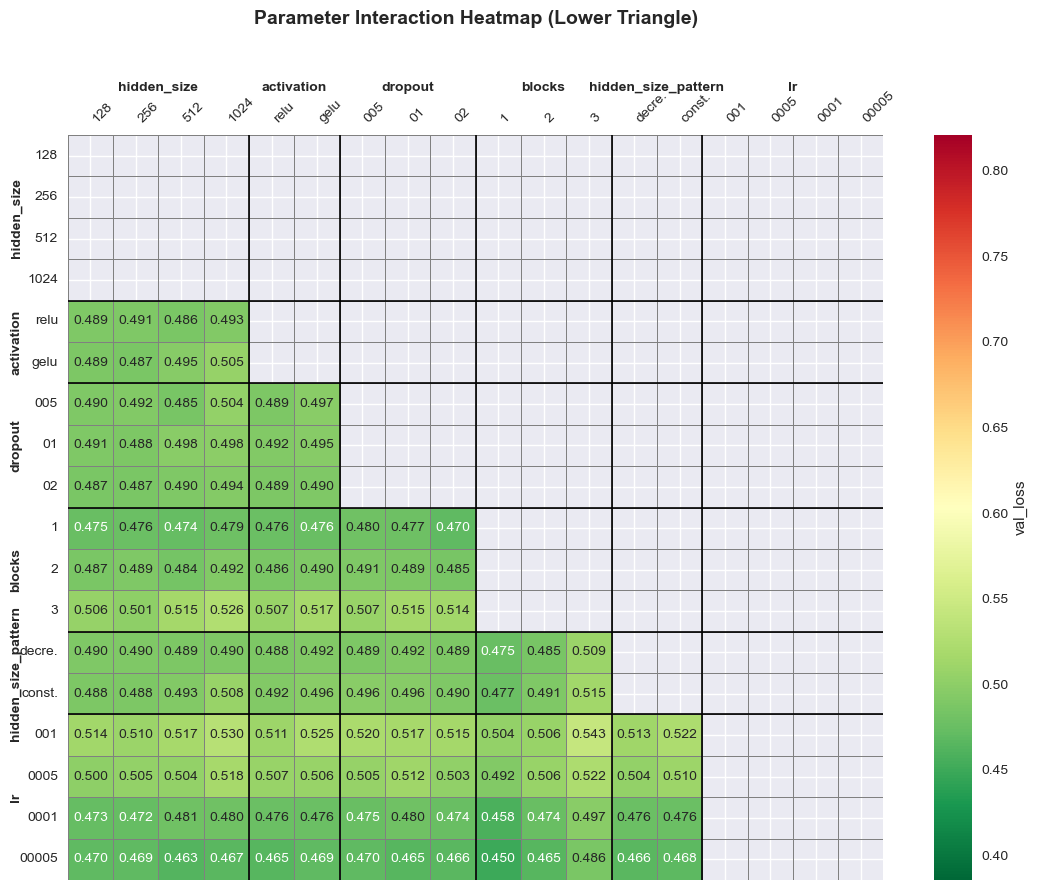



📈 Tuning results for TFIDF + VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
68,relu,1,0.2,128,constant,0.010,0.247116,0.404306,0.808140,0.648759,0.654706,0.651071
244,relu,3,0.1,512,constant,0.010,0.314905,0.413136,0.854651,0.673571,0.596226,0.626522
180,relu,2,0.2,512,constant,0.010,0.454004,0.422881,0.825581,0.658926,0.579020,0.610582
57,relu,1,0.1,1024,decreasing,0.005,0.307244,0.435693,0.802326,0.646216,0.569020,0.599190
84,relu,1,0.2,512,constant,0.010,0.386445,0.441961,0.825581,0.665810,0.571961,0.607336



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
244,relu,3,0.10,512,constant,0.0100,0.314905,0.413136,0.854651,0.673571,0.596226,0.626522
25,relu,1,0.05,1024,decreasing,0.0050,0.503988,0.456843,0.837209,0.664278,0.588726,0.617864
63,relu,1,0.10,1024,constant,0.0005,0.241007,0.477796,0.837209,0.667732,0.581667,0.615378
59,relu,1,0.10,1024,decreasing,0.0005,0.273709,0.455139,0.831395,0.661053,0.586226,0.614685
71,relu,1,0.20,128,constant,0.0005,0.361887,0.479320,0.831395,0.663405,0.499510,0.539361


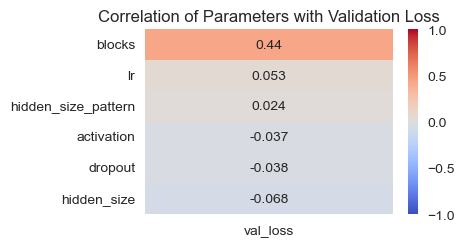

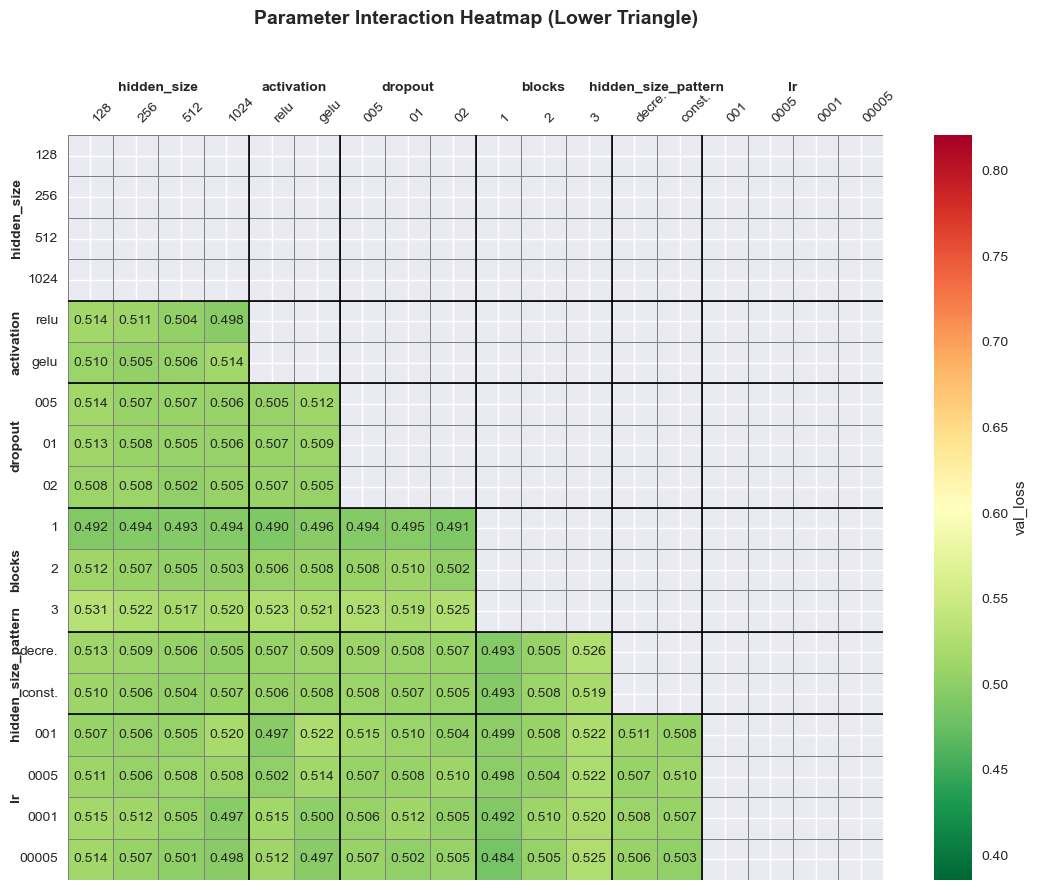



📈 Tuning results for BERT + CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
323,gelu,1,0.10,128,decreasing,0.0005,0.424671,0.548815,0.784884,0.641344,0.472451,0.513650
499,gelu,3,0.05,512,decreasing,0.0005,0.484161,0.549058,0.767442,0.628483,0.470833,0.507623
391,gelu,2,0.05,128,constant,0.0005,0.481125,0.550207,0.784884,0.638214,0.478333,0.516577
291,gelu,1,0.05,128,decreasing,0.0005,0.417314,0.551216,0.796512,0.645833,0.480980,0.521158
295,gelu,1,0.05,128,constant,0.0005,0.392932,0.551497,0.802326,0.653183,0.479951,0.522112



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
555,gelu,3,0.20,256,decreasing,0.0005,0.365344,0.577343,0.808140,0.491955,0.487157,0.488670
487,gelu,3,0.05,128,constant,0.0005,0.398675,0.570218,0.808140,0.655702,0.483627,0.525617
295,gelu,1,0.05,128,constant,0.0005,0.392932,0.551497,0.802326,0.653183,0.479951,0.522112
15,relu,1,0.05,256,constant,0.0005,0.353758,0.582599,0.802326,0.646620,0.488186,0.525647
546,gelu,3,0.20,128,decreasing,0.0010,0.434999,0.588248,0.796512,0.524603,0.478627,0.495940


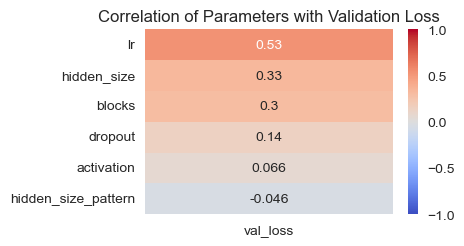

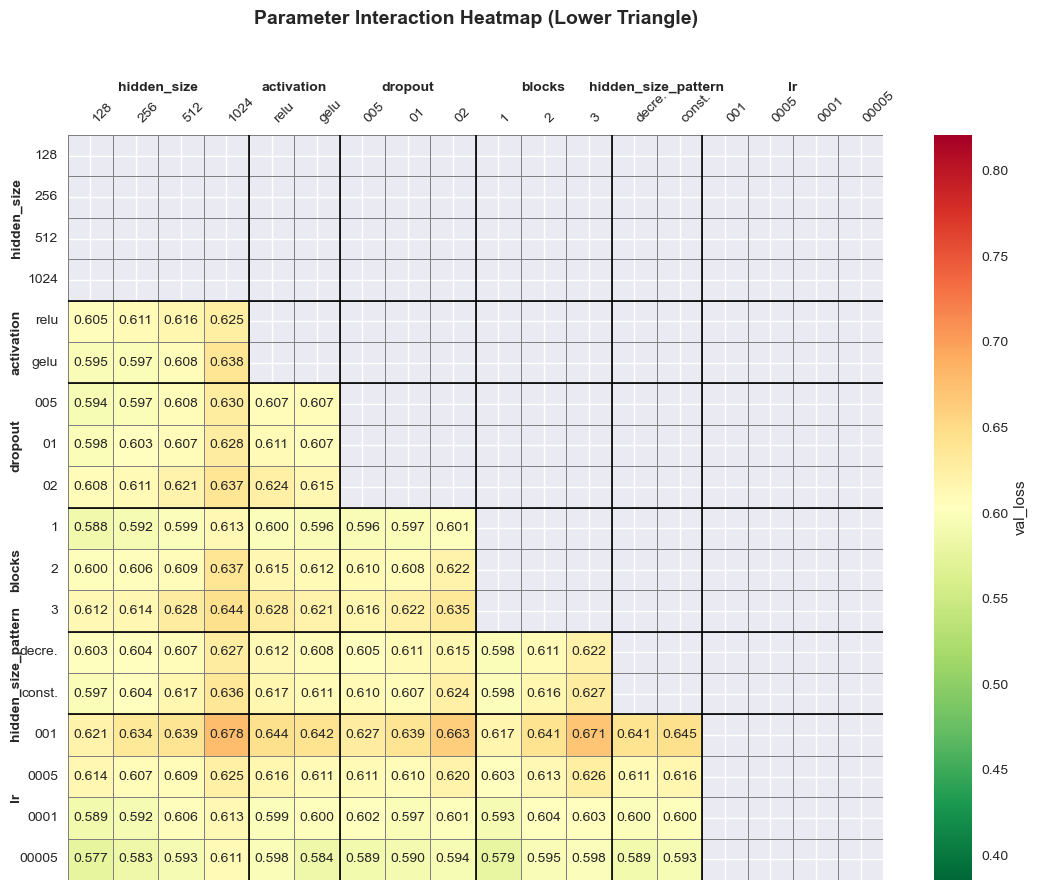



📈 Tuning results for BERT + RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
343,gelu,1,0.1,512,constant,0.0005,0.517588,0.532450,0.831395,0.580609,0.580343,0.580293
535,gelu,3,0.1,512,constant,0.0005,0.486576,0.544598,0.761628,0.502550,0.463627,0.478804
67,relu,1,0.2,128,decreasing,0.0005,0.430905,0.548328,0.802326,0.645714,0.567843,0.598406
351,gelu,1,0.1,1024,constant,0.0005,0.457028,0.549343,0.779070,0.515219,0.549608,0.528156
75,relu,1,0.2,256,decreasing,0.0005,0.471690,0.551797,0.761628,0.503211,0.461275,0.477404



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
343,gelu,1,0.1,512,constant,0.0005,0.517588,0.532450,0.831395,0.580609,0.580343,0.580293
362,gelu,1,0.2,256,decreasing,0.0010,0.409918,0.589766,0.802326,0.646739,0.487010,0.525177
67,relu,1,0.2,128,decreasing,0.0005,0.430905,0.548328,0.802326,0.645714,0.567843,0.598406
426,gelu,2,0.1,256,decreasing,0.0010,0.434378,0.561703,0.796512,0.523737,0.560637,0.538638
370,gelu,1,0.2,512,decreasing,0.0010,0.523963,0.570426,0.796512,0.522727,0.562990,0.539820


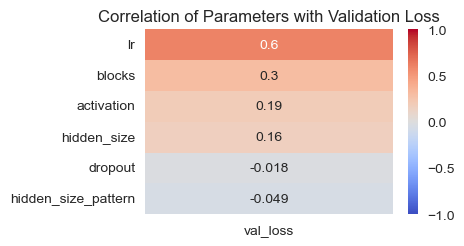

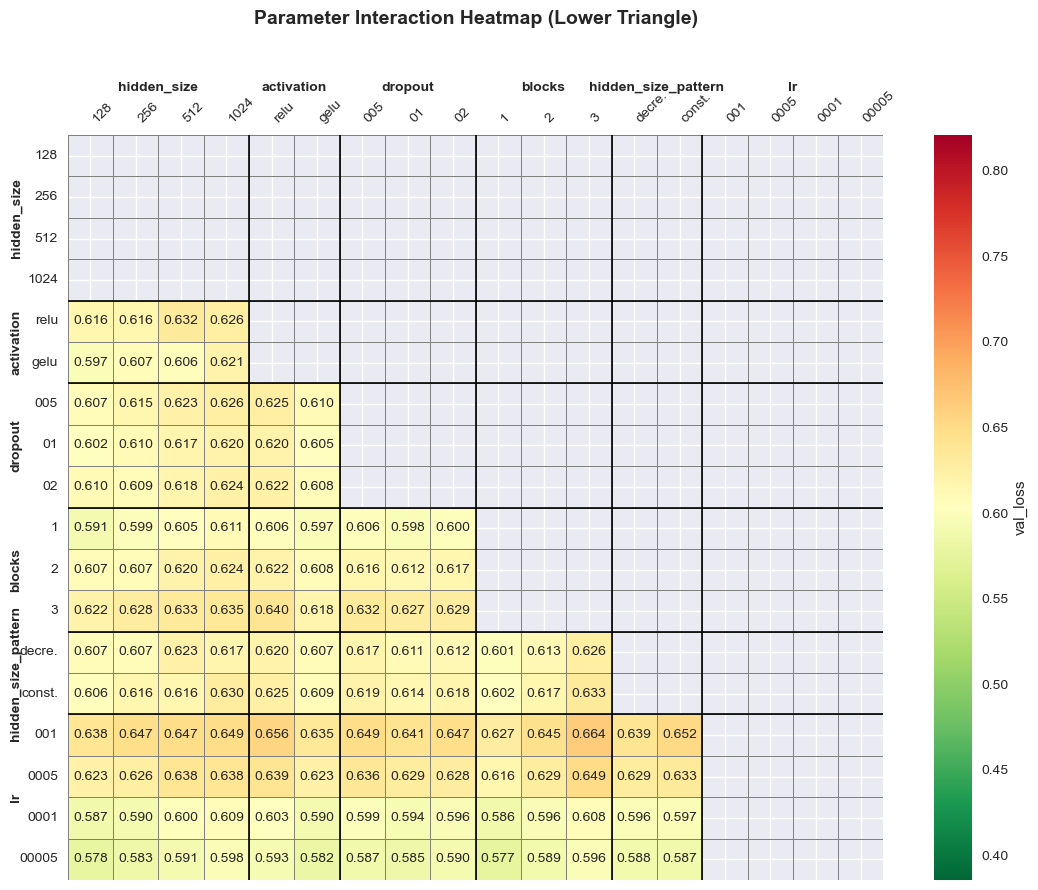



📈 Tuning results for BERT + VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
515,gelu,3,0.10,128,decreasing,0.0005,0.521741,0.562139,0.808140,0.534091,0.482451,0.500945
295,gelu,1,0.05,128,constant,0.0005,0.377291,0.567808,0.790698,0.640691,0.483186,0.520014
395,gelu,2,0.05,256,decreasing,0.0005,0.426757,0.568370,0.802326,0.646620,0.488186,0.525647
327,gelu,1,0.10,128,constant,0.0005,0.474555,0.574281,0.784884,0.637987,0.475980,0.515153
27,relu,1,0.05,1024,decreasing,0.0005,0.485042,0.574571,0.813953,0.652813,0.493186,0.531302



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
115,relu,2,0.05,512,decreasing,0.0005,0.483624,0.601325,0.831395,0.666959,0.495980,0.537754
299,gelu,1,0.05,256,decreasing,0.0005,0.454218,0.586272,0.831395,0.666959,0.495980,0.537754
3,relu,1,0.05,128,decreasing,0.0005,0.412861,0.589842,0.825581,0.658887,0.499363,0.537427
171,relu,2,0.20,256,decreasing,0.0005,0.330997,0.629364,0.825581,0.658662,0.500539,0.537842
219,relu,3,0.05,1024,decreasing,0.0005,0.452585,0.676335,0.825581,0.413690,0.413824,0.412294


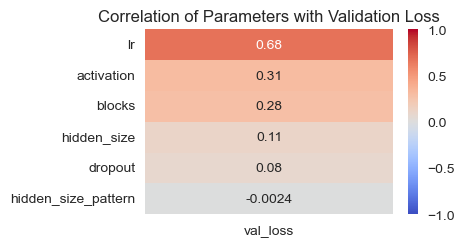

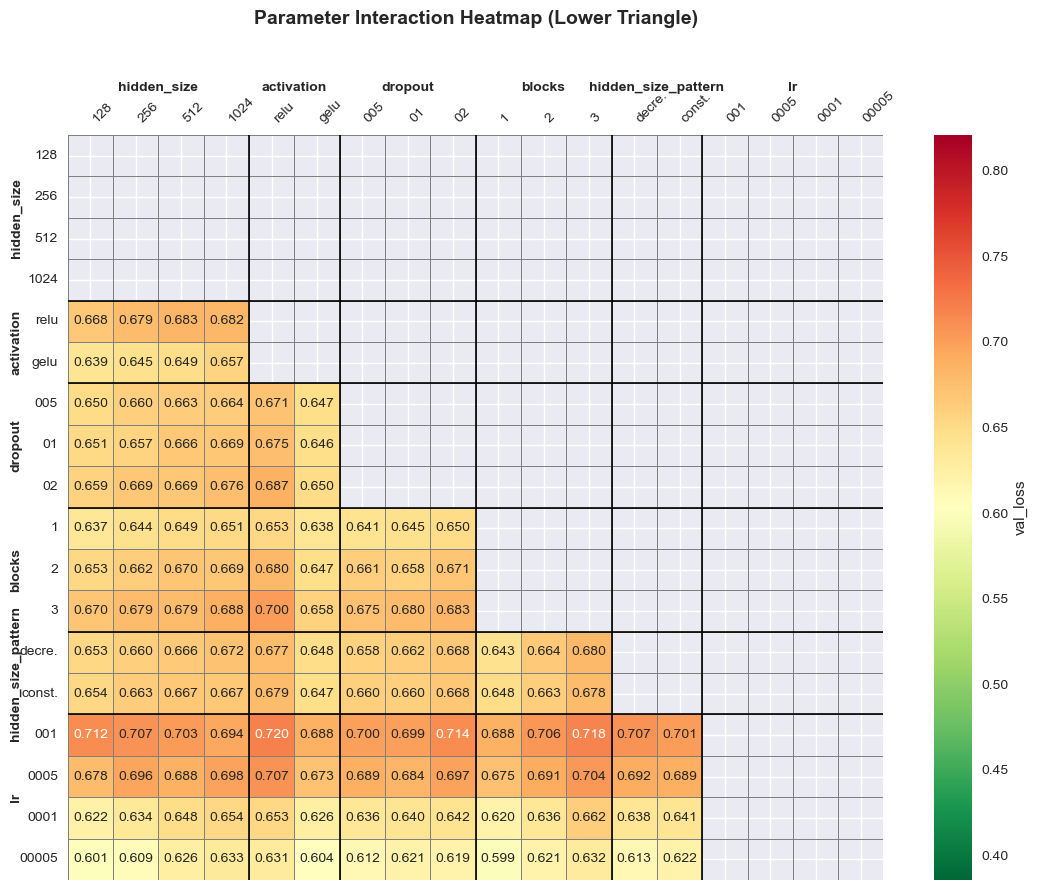

In [18]:
all_val_losses = pd.concat([tuning_history["val_loss"] for tuning_history in tuning_histories.values()])
val_loss_range = (all_val_losses.min(), all_val_losses.max())
print(val_loss_range)
for ft, tuning_history in tuning_histories.items():
    print(f"\n\n📈 Tuning results for {ft.upper()} features model:")
    print_tuning_top_results(tuning_history, topN=5, top_by=["val_loss", "accuracy"])

    plot_param_loss_corr(tuning_history, param_grid)
    plot_tuning_heatmap(tuning_history, param_grid, loss_range=val_loss_range)